### Preprocessing and Visualization

In [7]:
import tensorflow as tf
import os
import shutil

/Users/mrbinit/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
def load_dataset(directory, label):
    data = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as file:
            review = file.read()
            data.append((review, label))
    return data

directory_path = "/Users/mrbinit/Downloads/aclImdb" 

train_pos_dir = os.path.join(directory_path, 'train', 'pos')
train_neg_dir = os.path.join(directory_path, 'train', 'neg')
test_pos_dir = os.path.join(directory_path, 'test', 'pos')
test_neg_dir = os.path.join(directory_path, 'test', 'neg')
val_pos_dir = os.path.join(directory_path, 'val', 'pos')
val_neg_dir = os.path.join(directory_path, 'val', 'neg')

train_data = load_dataset(train_pos_dir, 1) + load_dataset(train_neg_dir, 0) #1 represents positive and 0 represents negative sentiments
test_data = load_dataset(test_pos_dir, 1) + load_dataset(test_neg_dir, 0)

#split the test set into a validation set (15,000 samples) and a test set (10,000 samples)
val_data = test_data[:15000]
test_data = test_data[15000:25000]

# #separate the reviews and labels from the train, test, and validation data
# train_reviews, train_labels = zip(*train_data)
# test_reviews, test_labels = zip(*test_data)
# val_reviews, val_labels = zip(*val_data)

# #check the lengths of train, test, and validation datasets
# train_length = len(train_reviews)
# test_length = len(test_reviews)
# val_length = len(val_reviews)

# print("Train dataset length:", train_length)
# print("Test dataset length:", test_length)
# print("Validation dataset length:", val_length)


# # convert lists to tensors
# train_reviews = tf.convert_to_tensor(train_reviews) # tensor are used to represent multi dimensional arrays which are important for GPU computation
# train_labels = tf.convert_to_tensor(train_labels)
# test_reviews = tf.convert_to_tensor(test_reviews)
# test_labels = tf.convert_to_tensor(test_labels)
# val_reviews = tf.convert_to_tensor(val_reviews)
# val_labels = tf.convert_to_tensor(val_labels)

# # Create datasets from tensor
# train_dataset = tf.data.Dataset.from_tensor_slices((train_reviews, train_labels)).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_reviews, test_labels)).batch(32)
# val_dataset = tf.data.Dataset.from_tensor_slices((val_reviews, val_labels)).batch(32)

# # Shuffle the training dataset
# train_dataset = train_dataset.shuffle(len(train_data))
# test_dataset = test_dataset.shuffle(len(test_data))
# val_dataset = val_dataset.shuffle(len(val_data))

Train dataset length: 25000
Test dataset length: 10000
Validation dataset length: 15000


#91% accuracy wiht over fitting

In [9]:
#Regular expressions (regex) are sequences of characters that define a search pattern. They are used for string manipulation, searching, and pattern matching within text. 
import re
def has_html_tags(text):
    pattern = re.compile(r'<[^>]+>')  # Regular expression to match HTML tags
    return bool(pattern.search(text))

# Check for HTML tags in each dataset
def check_html_tags(dataset):
    for review, _ in dataset:
        if has_html_tags(review):
            return True
    return False

#check for HTML tags in each dataset
train_has_html = check_html_tags(train_data)
test_has_html = check_html_tags(test_data)
val_has_html = check_html_tags(val_data)
#print output
print("Train dataset contains HTML tags:", train_has_html)
print("Test dataset contains HTML tags:", test_has_html)
print("Validation dataset contains HTML tags:", val_has_html)


Train dataset contains HTML tags: True
Test dataset contains HTML tags: True
Validation dataset contains HTML tags: True


In [10]:
def has_url(text):
    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return bool(pattern.search(text))

#condition to check for url
def check_for_urls(dataset):
    for review, _ in dataset:
        if has_url(review):
            return True
    return False
#check whether there is URL or not
train_has_url = check_for_urls(train_data)
test_has_url = check_for_urls(test_data)
val_has_url = check_for_urls(val_data)

print("Train dataset contains URLs:", train_has_url)
print("Test dataset contains URLs:", test_has_url)
print("Validation dataset contains URLs:", val_has_url)

Train dataset contains URLs: True
Test dataset contains URLs: True
Validation dataset contains URLs: True


In [11]:
def has_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    return bool(pattern.search(text))

def check_for_special_characters(dataset):
    for review, _ in dataset:
        if has_special_characters(review):
            return True
    return False

train_has_special_chars = check_for_special_characters(train_data)
test_has_special_chars = check_for_special_characters(test_data)
val_has_special_chars = check_for_special_characters(val_data)
print("Train dataset contains special characters:", train_has_special_chars)
print("Test dataset contains special characters:", test_has_special_chars)
print("Validation dataset contains special characters:", val_has_special_chars)


Train dataset contains special characters: True
Test dataset contains special characters: True
Validation dataset contains special characters: True


In [12]:
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import contractions
from spellchecker import SpellChecker  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mrbinit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mrbinit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
#load the English model
nlp = spacy.load("en_core_web_sm")

#initialize the spell checker
spell_checker = SpellChecker()

#identifies stop words and removes
def remove_Stop_words(text):
    #expand contraction 
    expanded_text = contractions.fix(text)
    words = word_tokenize(expanded_text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def data_cleaning(text):
    #convert text to lower case
    text = text.lower()
    #remove HTML tags
    clean_text = re.sub(r'<.*?>', '', text)
    #remove URLs
    clean_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', clean_text)
    #remove special characters
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', clean_text)
    #handles stop words
    clean_text = remove_Stop_words(clean_text)
    return clean_text

#function to extend words using spaCy
def extend_words_with_spacy(text):
    doc = nlp(text)
    extended_text = ' '.join([token.lemma_ for token in doc])
    return extended_text

#function to check spelling
def spell_check(text):
    corrected_text = ' '.join([spell_checker.correction(word) for word in text.split()])
    return corrected_text

#apply data cleaning, lemmatization. and word extension to validation data
cleaned_train_data = []
for review, label in train_data:
    cleaned_review = data_cleaning(review)
#check if cleaned_review is not None
    if cleaned_review is not None:  
        cleaned_review = extend_words_with_spacy(cleaned_review)
        cleaned_train_data.append((cleaned_review, label))
    else:
        print("Skipping review with None result after cleaning:", review)

#apply data cleaning, lemmatization. and word extension to test data
cleaned_test_data = [(extend_words_with_spacy(data_cleaning(review)), label) for review, label in test_data]

#apply data cleaning, lemmatization. and word extension to validation data
cleaned_val_data = [(extend_words_with_spacy(data_cleaning(review)), label) for review, label in val_data]



In [14]:
print("Cleaned Train Data:", cleaned_train_data[:5])  
print("Cleaned Test Data:", cleaned_test_data[:5])   
print("Cleaned Validation Data:", cleaned_val_data[:5])

Cleaned Train Data: [('movie get respect sure lot memorable quote list gem imagine movie joe piscopo actually funny maureen stapleton scene stealer moroni character absolute scream watch alan skipper hale jr police sgt', 1), ('bizarre horror movie fill famous face steal cristina rain later tvs flamingo road pretty somewhat unstable model gummy smile slate pay attempt suicide guard gateway hell scene rain model well capture mood music perfect deborah raffin charming cristinas pal raine move creepy brooklyn height brownstone inhabit blind priest top floor thing really start cook neighbor include fantastically wicked burgess meredith kinky couple sylvia miles beverly dangelo diabolical lot eli wallach great fun wily police detective movie nearly crosspollination rosemarys baby exorcistbut combination base bestseller jeffrey konvitz sentinel entertainingly spooky full shock bring well director michael winner mount thoughtfully downbeat end skill 12', 1), ('solid unremarkable film matthau e

In [15]:
train_data_length = len(cleaned_train_data)
test_data_length = len(cleaned_test_data)
val_data_length = len(cleaned_val_data)

#print the lenght of the data
print('the size of train data is: ', train_data_length)
print('the size of test data is: ', test_data_length)
print('the size of valid data is: ', val_data_length)



the size of train data is:  25000
the size of test data is:  10000
the size of valid data is:  15000


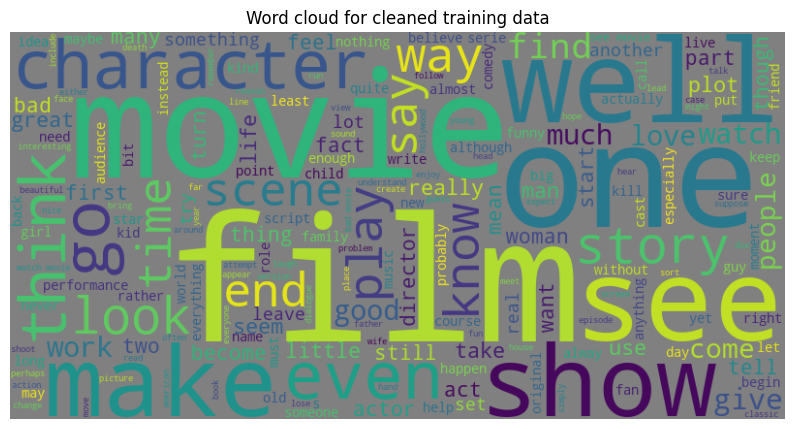

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#extract preprocessed text from cleaned
cleaned_text = ' '.join([review for review, _ in cleaned_train_data])  

#generate word cloud 
wordcloud = WordCloud(width= 800, height = 400, background_color= 'grey').generate(cleaned_text)

plt.figure(figsize= (10, 6))
plt.imshow(wordcloud, interpolation= 'bilinear') #interpolation refers to values or pixels in the image when the image is zoomed or resized
plt.title("Word cloud for cleaned training data")
plt.axis('off')
plt.show()

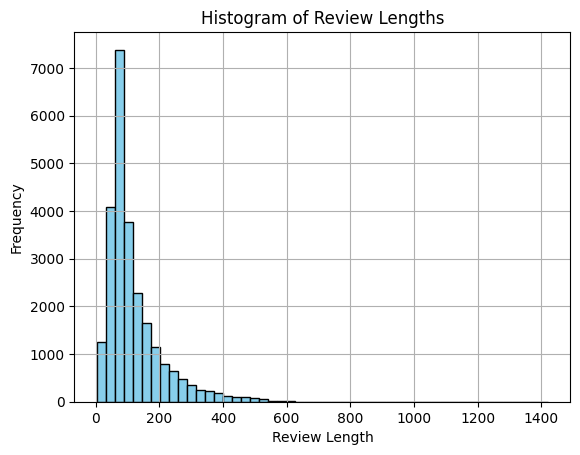

In [20]:
#get the lengths of reviews
review_lengths = [len(review.split()) for review, label in cleaned_train_data]

#plot histogram
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths')
plt.grid(True)
plt.show()


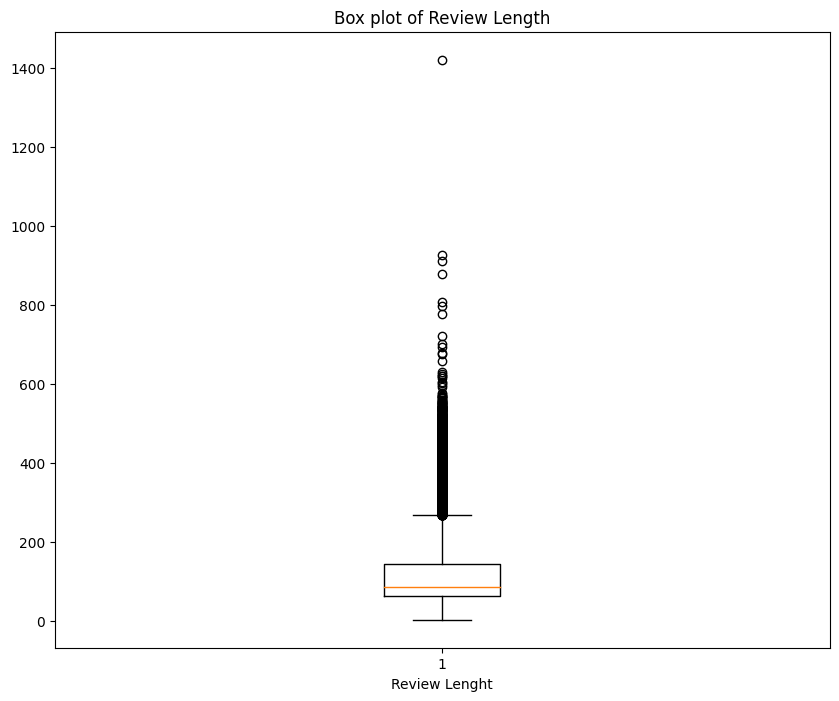

In [25]:
#Plot the box plot for review length 

plt.figure(figsize= (10, 8))
plt.boxplot(review_lengths)
plt.xlabel('Review Lenght')
plt.title('Box plot of Review Length')
plt.show()

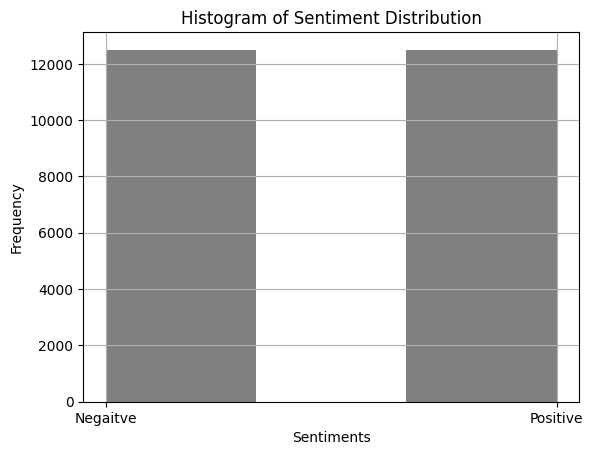

In [28]:
sentiments = [label for review, label in cleaned_train_data]

#plot histogram
plt.hist(sentiments, bins = 3, color =  'grey')
plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Distribution')
plt.xticks([0,1], ['Negaitve', 'Positive'])
plt.grid(True)
plt.show()

In [32]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


In [33]:
#tokenize the cleaned data 
tokenized_train_data = [word_tokenize(review) for review, label in cleaned_train_data]
tokenized_test_data = [word_tokenize(review) for review, label in cleaned_test_data]
tokenized_val_data = [word_tokenize(review) for review, label in cleaned_val_data]

#train word2vec model 
word2vec_model = Word2Vec(sentences= tokenized_train_data + tokenized_test_data + tokenized_val_data, vector_size = 100, window = 5, min_count= 1, workers=4)
print("Word vector for good: ", word2vec_model.wv['good'])


Word vector for good:  [ 1.9351434  -0.31649768  1.262604    0.2485447  -0.58590657  1.1447334
  1.6378986  -0.9555036   0.17863788  0.19655432  0.72506636  2.2987347
  0.6410356   0.41170198  0.13393916 -0.5138415   2.2073905   1.1926681
 -0.8597899   0.12427133  1.0206218  -1.4151982   2.2941568  -1.8644361
  0.6029031   2.0038044  -1.4944118  -0.41074565  0.21410982  0.6397253
  3.533351    0.74699986  1.9699707  -0.6600061  -1.8955178   0.2585533
 -1.3829379  -1.1912663  -1.7690425  -3.7538886   0.58716416 -0.25263765
  2.2120006  -1.9003521   0.66793567 -1.0611118  -1.0682484  -1.8245424
 -0.77451724 -0.9995276   0.07836226 -0.9475449  -2.18305    -0.38159043
  1.010164   -1.9613837   0.49969324 -0.8882624  -0.18544757 -1.6566453
 -0.05173353 -0.7974785   2.1322515   1.0976228  -0.89469516  0.60422283
  0.45022607 -0.95702577 -1.898331    0.08684856 -0.52853525  1.8484128
  0.5200404   0.80231327  0.99117166  0.22368106  0.5402723   0.59218067
  0.44347098  1.2181314   0.72144586 